
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/Banner_IA2_1.png" style="width:1500px;heigth:100px">



# <center> 08. TEMPORAL SERIES ANALYSIS: FROM CLASSICAL AND RNN MODELS </center>



## <span style="color:red"> Outline </span> 
1. **Sequences and Time series**
2. **Forecasting: preparing data**
3. **Forecasting from classical models**
4. **Forecasting from RNN models**



In [ ]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/course-IA2')
print(os.getcwd())

In [ ]:
#@title Load libraries { display-mode: "form" }
#@markdown Here is important to change to GPU  

import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
print(tf.__version__)

2.2.0


#**1. Sequences and Time series**

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/applications.png" style="width:900;height:450px;">

Time series is everywere from signals thar represent monitoring industrial processes to series that track corporate business metrics. Other applications include economic, sales and Weather forescasting. So, time series are **ordered sequences**, equally spaced in time intervals, that can be modelled as: 
* Additive Model: $y_t =T_t+S_t+C_t+R_t$ 
* Multiplicative Model: $y_t =T_t \times S_t \times C_t \times R_t$


### **1.1 Components of time series**

* **Trend:** represents the increase or decrease pattern (tendency) during a long period of time. A trend is a smooth, general, and observed in long-term windows, being described by average tendency. This component is namely observed  as a persistent, overall upward or downward pattern over time that does not repeat. 

* **Seasonality:** refers to regular periodic components that are added  to original signal, with a fixed and know frequency. Then, seasonality are cycles that repeat regularly over time.

* **Cyclic:** A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. The cyclic variation may be regular are not periodic. 
* **Noise:** is a non-systematic component that causes  non regular variations purely random or irregular. These fluctuations are unforeseen, uncontrollable, unpredictable, and are erratic.


Most time series  can be described in terms of trend and seasonality, which may coexist in real-life data.


The main components and signal properties of signals, can be analized in next plot


In [ ]:
#@title **code** Time series components  { display-mode: "form" }
import matplotlib.pyplot as plt
import numpy as np

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, amplitude =10, slope=1, e=0):
    return amplitude + (slope * time) + e

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1, np.cos(season_time * 6 * np.pi), 2 / np.exp(9 * season_time))

def seasonality(time, period=12, amplitude=1, phase=0, e=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time) + e

def cyclic_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1, np.sin(season_time * 2 * np.pi), 4 / np.exp(season_time))

def cyclic(time, period, amplitude=1, phase=0, e=0):
    """Repeats the same pattern at different period"""
    cyclic_time1 = ((time + phase) % period) / period
    cyclic_time2 = ((time + phase) % ((np.random.RandomState(0).randn(len(time)) ))) / np.random.RandomState(0).randn(len(time))
    cyclic_time = cyclic_time1 + cyclic_time2
    return amplitude * cyclic_pattern(cyclic_time) + e   

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
    
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude
    
def sequential_patterns_plot():
    import ipywidgets as widgets
    from ipywidgets import interact
    import matplotlib.pyplot as plt
    import numpy as np 
    
    @widgets.interact(
        pattern=['trend', 'seasonality', 'cyclic','noise','seasonality + trend', 'seasonality + trend + noise','seasonality + trend + cyclic + noise', 'autocorrelation',], slope=(0.01, 1.), amplitude=(10,100), noise_level=(1,50))

    def plot(pattern='trend', period=(1,365), slope=0.05, amplitude=40, noise_level=20 ,grid=True):
        time = np.arange(4 * period + 1, dtype="float32")
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        if pattern=='trend':
            plt.title(pattern)
            series = trend(time,slope)  
            plot_series(time, series)
            ax.grid(grid)
        elif pattern=='seasonality':
            plt.title(pattern)
            series = seasonality(time, period=period, amplitude=amplitude)
            plot_series(time, series)
            ax.grid()
        elif pattern=='cyclic':
            plt.title(pattern)
            series = cyclic(time, period=period, amplitude=amplitude)
            plot_series(time, series)
            ax.grid()
        elif pattern=='noise':
            plt.title(pattern)
            series = noise(time, noise_level, seed=42)
            plot_series(time, series) 
            ax.grid()   
        elif pattern=='seasonality + trend':
            plt.title(pattern)
            trend_component = trend(time, slope)
            seasonality_component = seasonality(time, period=period, amplitude=amplitude)
            series =  trend_component + seasonality_component  
            plot_series(time, series)
            ax.grid()
        elif pattern=='seasonality + trend + noise':
            plt.title(pattern)
            trend_component = trend(time, slope)
            seasonality_component = seasonality(time, period=period, amplitude=amplitude)
            noise_component = noise(time, noise_level, seed=42)
            series =  trend_component + seasonality_component + noise_component 
            plot_series(time, series)
            ax.grid()  
        elif pattern=='seasonality + trend + cyclic + noise':
            plt.title(pattern)
            trend_component = trend(time, slope)
            seasonality_component = seasonality(time, period=period, amplitude=amplitude)
            cyclic_component = cyclic(time, period=period, amplitude=amplitude)
            noise_component = noise(time, noise_level, seed=42)
            series =  trend_component + seasonality_component + cyclic_component + noise_component 
            plot_series(time, series)
            ax.grid()               
        elif pattern=='autocorrelation':
            plt.title(pattern)
            series = autocorrelation(time, amplitude, seed=42)
            plot_series(time, series)
            ax.grid()

        return None 

sequential_patterns_plot()          

interactive(children=(Dropdown(description='pattern', options=('trend', 'seasonality', 'cyclic', 'noise', 'sea…

### **1.2 Time series preprocessing and analysis**

- **Smoothing:**
 involves  a local averaging to cancel out independent observations and among others identify trend or reduce noise. 
 
 
 . The most common technique is ***moving average smoothing*** which replaces each element of the series by either the simple or weighted average of n surrounding elements, where n is the width of the smoothing "window". In the relatively less common cases (in time series data), when the measurement error is very large, the distance weighted least squares smoothing or negative exponentially weighted smoothing techniques can be used.

 If the time series data contain considerable error, then the first step in the process of trend identification is smoothing. 





(1461,) (1461,)


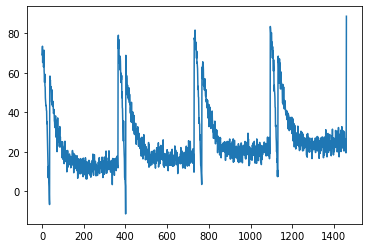

In [ ]:
#@title **code** To create series by combining patterns
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, slope=0.01)+ seasonality(time, period=365, amplitude=60) + noise(time, noise_level=3, seed=51)
print(time.shape, series.shape)
plt.plot(time, series, label='serie')

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Now, create a function that implement a moving average smoothing given the previous input sequence. At each time, it should be taken the next data (in a window_size) and replace by the mean. For instance, in a window_size=3, with mean operator: 


```
0 [69.12849048 70.26639208 73.45263409] 70.94917221412841
1 [70.26639208 73.45263409 65.22869331] 69.64923982309317
2 [73.45263409 65.22869331 69.06420294] 69.24851011244102
3 [65.22869331 69.06420294 67.91690163] 67.40326596011592
```

- Change mean operator for median
- Change windows_size

In [ ]:
#@title **code student** create a moving average smoothing
def moving_average_smoothing(series, window_size=5):
  forecast = []
  
   ......
   ......

  return np.array(forecast)
# Apply Moving average smoothing  
window_size=10
moving_avg = moving_average_smoothing(series, window_size=10)  

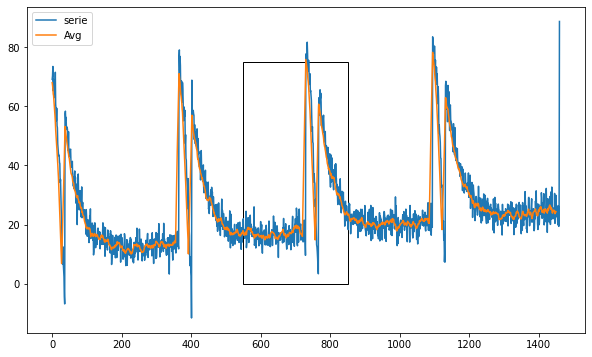

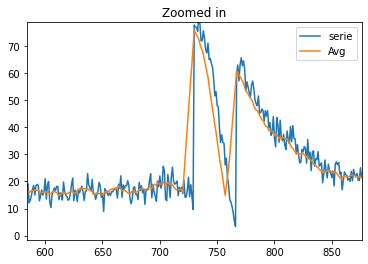

In [ ]:
#@title **code** Plot Moving Average Smoothing { display-mode: "form" }
# plot
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(10, 6))
p = plt.Rectangle((550, 0), width=300, height=75, fill=False)
ax = plt.gca()#get axes
ax.add_patch(p)
plt.plot(time, series, label='serie')
plt.plot(time[:-window_size], moving_avg, label='Avg')
plt.legend()
plt.show()
# zoomed in
plt.margins(x=-0.4, y=-0.1) 
plt.plot(time, series, label='serie')
plt.plot(time[:-window_size], moving_avg, label='Avg') # plot to minus the window.
plt.title('Zoomed in')
plt.legend()
plt.show()

- **Differentiating:** commonly used to eliminate the seasonality dependencies by converting the series to a stationary type. The simplest way result on difference sucesive $i$ elements (or w.r.t the lag period $k$) of the serie ($i-k$). 

  - Lag =1 , the autocorrelation  is between $y_t$ and $y_{t-1}$, Lag=2 is $y_t, y_{t-2}$
  - Another way is related with correlograms (autocorrelograms) that uses corelation function (ACF). Horizontal axis is time lag and vertical axis is correlation coefficient. 
    - autocorrelation is $$r_{k} = \frac{\sum_{i=1}^{N-k} (Y_i- \bar{Y})(Y_{i+k}-\bar{Y}) }{\sum_{i=1}^{N}(Y_i - \bar{Y})^{2}}$$
    - **Are the data random?** R:/ If autocorrelation is zero, probabily data is random

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Implement a function to differentiate series, taking into account an specific period. 

- `diff_series` is the difference resulting serie
- `diff_time` is the corresponding horizontal axis



1461 1096 1096


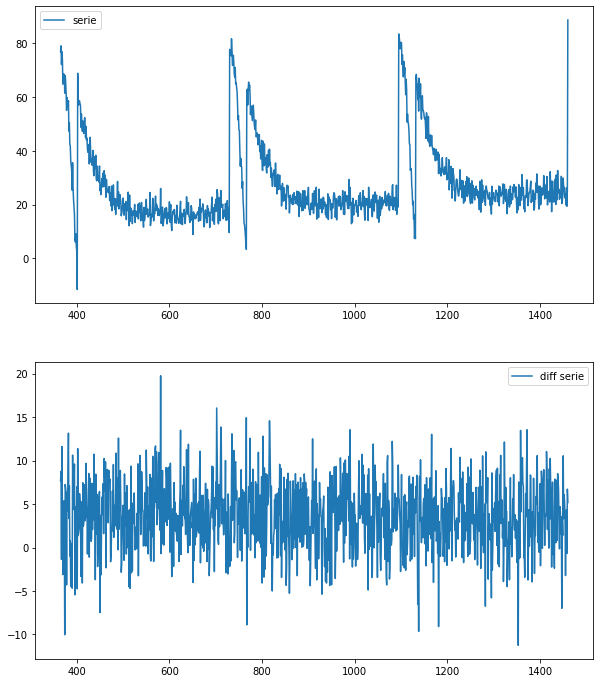

In [ ]:
#@title **code student** differentiating series and plotting results
def diff_func(series, period=365): 
  diff_series = ...
  diff_time = ...
  return diff_series, diff_time

period=365
diff_series, diff_time = diff_func(series, period)

print(len(series), len(diff_series), len(diff_time))

fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(time[period:], series[period:], label='serie')
axs[0].legend()
axs[1].plot(diff_time, diff_series, label='diff serie')
plt.legend()
plt.show()  

#**2. Forecasting: preparing data**


In machine learning, a fundamental problem is **forecasting** over temporal series. To prepare data to acess over such models, we need to do a special configuration in data. In this case, training, validation and test sets are defined as follows: 

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/setsplit.png" width="600" height="400">

**Remember** 

In this regression problems, we define error as the different between forecast $f_t$ and actual value $y_t$, as: $error = f_t - y_t$. Typical metrics to measure this errors are: **the mean square error** ($mse = \frac{1}{N}\sum_{t=1}^{N}(f_t - y_t)^2$) or the **mean absolute error** ($mae = \frac{1}{N}\sum_{t=1}^{N}|f_t - y_t|$)

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Implement a function that split serie in training, validation and test, according to some input sizes. 

- Split both: series `series_split` and corresponding time `time_split`
- Return  a list with the three respective sub-lists




 




In [ ]:
#@title **code student** split series
def split_series(time, serie, train_rate=0.5, test_rate=0.25, validation_rate=0.25):
    num_examples = len(serie)
    # split series in train, validation and test sets
    series_split = ...
    # split time for train, validation and test series
    time_split = ...                    
    
    return time_split, series_split

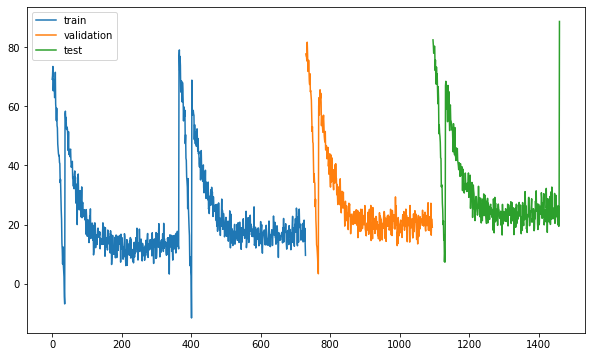

In [ ]:
#@title **code** plot the resultant splits
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, slope=0.01)+ seasonality(time, period=365, amplitude=60) + noise(time, noise_level=3, seed=51)

time_sets, series_sets = split_series(time, series)
fig = plt.figure(figsize=(10, 6))
plt.plot(time_sets[0], series_sets[0], label='train')
plt.plot(time_sets[1], series_sets[1], label='validation')
plt.plot(time_sets[2], series_sets[2], label='test')
plt.legend()
plt.show()

#**3. Forecasting from classical models**

We can use previous models and also deep learning models to forecasting from time series. Regarding, classical models we can formulate for instance a weather forecasting model. For doing so, first: 

- Load dataset of temperature in Australia
- Split the dataset on training, validation and set


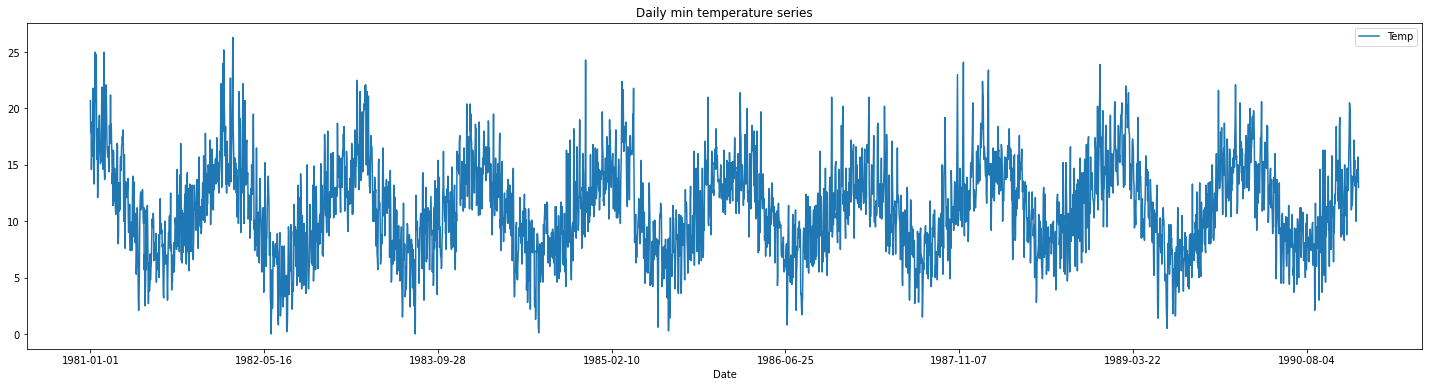

In [ ]:
#@title **code:** load and visualize the data
data_tem = pd.read_csv("data/dailyMin_temperatures.csv")
ax = data_tem.plot(x='Date',title='Daily min temperature series', figsize=(25, 6));
#@title Plot train, validation and test series { display-mode: "form" }data_tem.head()    

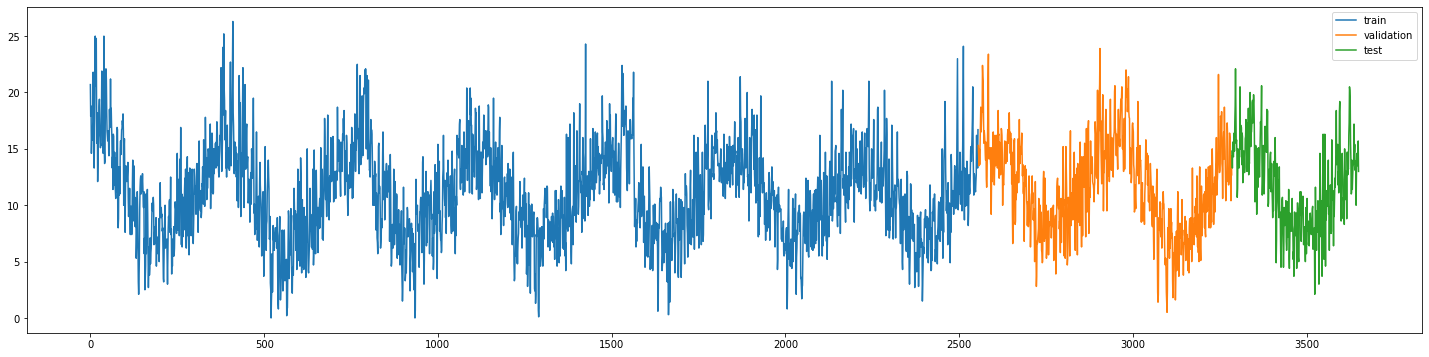

In [ ]:
#@title **code** Plot train, validation and test series { display-mode: "form" }
time_sets, series_sets = split_series(time=data_tem.index.values, serie=data_tem.Temp.values, train_rate=0.7, validation_rate=0.20, test_rate=0.10)

fig = plt.figure(figsize=(25, 6))
plt.plot(time_sets[0], series_sets[0], label='train')
plt.plot(time_sets[1], series_sets[1], label='validation')
plt.plot(time_sets[2], series_sets[2], label='test')
plt.legend()
plt.show()

Now, we can implement an moving average forescasting model, as: 


$$f_t= \underset{\underbrace{\text{previous}}}{\alpha y_{t-1}} + \underset{\underbrace{\text{lag e}}}{\beta y'_{t-365}} + \underset{\underbrace{\text{local e}}}{\rho \sum_{w=1}^{10}y_{t-w}}$$


where, $\alpha + \beta + \rho = 1$

- $y_{t-1}$ is the previous value
- $y'_{t-365}$ *(lag e)* is the local error ($y_t-y_{t-1}$) at previos lag value.
- $\sum_{w=1}^{10}y_{t-w}$ is the average moving estimation


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

1. Implement a function to Differentiate serie to obtain ($y_t-y_{t-1}$)  and get easily $y'_{t-365}$ as `diff_serie` 
2. Implement moving average function that return a serie  `serie_avg` with values regarding a window w, so:

  2.1 return $\bar{y_i} = y_i$ for $i < w$
  
  2.2 return $\bar{y_i} = mean(y_{i-w}: y_{(i-w) + (w-1)}) $

3. Explains **forecasting** 



In [ ]:
#@title **code student** implements the differentiating serie
def differentiating(serie): 
  return ...

diff_serie = differentiating(data_tem.Temp.values)

In [ ]:
#@title **code student** implements the moving average forescasting
def moving_average_forecasting(series, window_size=5):
  forecast = []
  for time in range(len(series)):
    if time < window_size:
        forecast.append( .... )
    else:
        forecast.append(....)
  return np.array(forecast)

n_window = 30 
serie_avg = moving_average_forecasting(data_tem.Temp.values, window_size=n_window)

In [ ]:
#@title **code**  walk forward forecasting 
alpha = 0.9  
beta = 0.05
rho = 0.05
serie = data_tem.Temp.values
len_n = len(serie)
validation_init = int(len_n*0.7)
test_init = int(len_n*0.9)

forecast_validation = []
forecast_test = []

forecast_tmp = serie[test_init]

for t in range(len_n-1):
    if t >= validation_init and t < test_init:
        forecast = alpha*serie[t-1] + beta*diff_serie[t-365] + rho*serie_avg[t]
        forecast_validation.append(forecast)
    elif t >= test_init:
        forecast = alpha*forecast_tmp + beta*diff_serie[t-365] + rho*serie_avg[t]
        forecast_tmp =  forecast#serie[t-1]#forecast
        forecast_test.append(forecast_tmp)


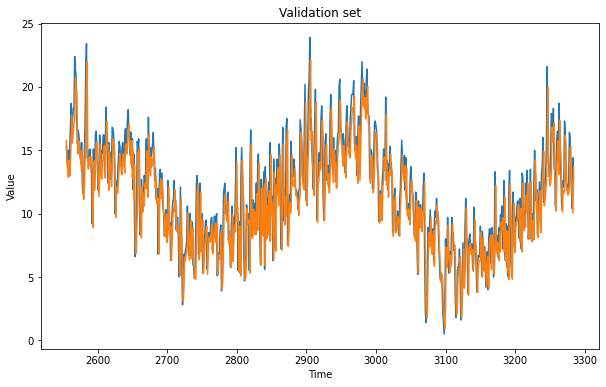

MSE in validation set 6.435535230645187
MAE in validation set 2.001141709966934


In [ ]:
#@title plot forecast in validation { display-mode: "form" }
plt.figure(figsize=(10, 6))
plt.title('Validation set')
plot_series(time_sets[1], series_sets[1])
plot_series(time_sets[1], forecast_validation)
plt.show()
print('MSE in validation set', tf.keras.metrics.mean_squared_error(series_sets[1], forecast_validation).numpy())
print('MAE in validation set', tf.keras.metrics.mean_absolute_error(series_sets[1], forecast_validation).numpy())

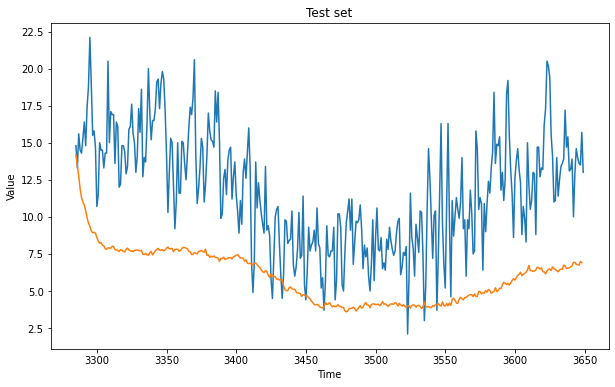

MSE in test set 41.093609211328214
MAE in test set 5.700812132118149


In [ ]:
#@title plot forecast in test { display-mode: "form" }
plt.figure(figsize=(10, 6))
plt.title('Test set')
plot_series(time_sets[2], series_sets[2])
plot_series(time_sets[2][:-1], forecast_test)
plt.show()
print('MSE in test set', tf.keras.metrics.mean_squared_error(series_sets[2][:-1], forecast_test).numpy())
print('MAE in test set', tf.keras.metrics.mean_absolute_error(series_sets[2][:-1], forecast_test).numpy())


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

1. 
- The method in test is OK?
- Change weights and  Observe performance of the signal. 

 



### **3.3 Advantages and limitations**

- Easy to implement and faster
- You shhlud know main components of signals
- You need to fix weights 

#**4. Forecasting from RNN models**
 Same forecasting problem can be solved with deep neural networks with main advantage to learn weigths of history serie and also to be adaptable to very non linear changes, commonly in time series of real scenarios. 

Firstly we need to arrange dataset for training net, in sense that works as illustrated in next figure: 

### **4.1 Built the dataset for Tensorflow and RNN**
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/sliding_dataset.gif" style="width:700;height:350px;"> 

Tensorflow help with this construction using `from_tensor_slices`. For instance for a serie: 

```
[0, 1, 2, 3, 4, 5, 6, 7]
```

Firstly split data and  create the windows shifted 1 position (
`dataset.window()`): 

```
[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
```
Then, choose for $t-w$ features for $t$ value: 

```
[0, 1, 2, 3][4]
[1, 2, 3, 4][5]
[2, 3, 4, 5][6]
```
 Then shuffle data. See the function as follows: 







In [ ]:
#@title **code** building the dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position, 
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # choose t --> t-1 as a features and the last one as a label
    # [0, 1, 2, 3][4]
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # shuffle the data
    dataset = dataset.shuffle(shuffle_buffer)
    # Generate the batches
    # x = [[0, 1, 2, 3], [4, 5, 6, 7]]
    # y = [[4], [8]]
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
#@title **code** create the dataset for RNN

window_size = 30 # number of features in a window
batch_size = 128 # number of samples 
shuffle_buffer_size = 1000 # shuffle the first 1000 samples
per_test = 0.3 # percentage of data to test

# Split series into train, validation and test 
# load data
data_tem = pd.read_csv("data/dailyMin_temperatures.csv")
serie = data_tem.Temp.values
len_n = len(serie)
time = data_tem.index.values
time_sets, series_sets = split_series(time=time, serie=serie, train_rate=0.7, validation_rate=0.20, test_rate=0.10)

dataset = windowed_dataset(series_sets[0], window_size=window_size, batch_size=32, shuffle_buffer=100)

We can visualize the dataset arrangement as follows: 

In [ ]:
#@title **code** to visualize data into dataset
for i, (x,y) in enumerate(dataset):
  if i == 0:
    print('Number of samples in each batch: ', x.numpy().shape[0])
    print('Number of labels in each batch: ', y.numpy().shape[0])
    print('Number of features of each sample (temperature days): ', x.numpy().shape[1])
    print('---------------------')
    print('X_1 = \n', x.numpy()[1])
    print('\n')
    print('Y_1 = ', y.numpy()[1])

Number of samples in each batch:  32
Number of labels in each batch:  32
Number of features of each sample (temperature days):  30
---------------------
X_1 = 
 [20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5
 25.  20.7 20.6 24.8 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2
 15.5 15.1]


Y_1 =  15.4


### **4.2 Built the RNN**

In [ ]:
#@title **code** Building  the RNN model

# Define the layers ######################################################## 
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input(window_size)
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model = tf.keras.Model(inputs=input_, outputs=y)
model.summary()






Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
InputTransform (Lambda)      (None, 30, 1)             0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 30, 20)            440       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
ouput_layer (Dense)          (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________



<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- How is the resultant RNN architecture from previous model?


In [ ]:
#@title **code** Now we proceed to train the model 

# Clear the previous sessions and set the seed 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9))  
# fit
history = model.fit(dataset,epochs=20,verbose=1)

Epoch 1/20
79/79 [==============================] - 5s 63ms/step - loss: 5.9570 - mse: 5.9570 - mae: 1.8923
Epoch 2/20
79/79 [==============================] - 5s 62ms/step - loss: 5.9204 - mse: 5.9204 - mae: 1.8921
Epoch 3/20
79/79 [==============================] - 5s 60ms/step - loss: 5.9748 - mse: 5.9748 - mae: 1.9009
Epoch 4/20
79/79 [==============================] - 5s 61ms/step - loss: 5.9759 - mse: 5.9759 - mae: 1.9050
Epoch 5/20
79/79 [==============================] - 5s 61ms/step - loss: 6.0876 - mse: 6.0876 - mae: 1.9169
Epoch 6/20
79/79 [==============================] - 5s 60ms/step - loss: 5.9573 - mse: 5.9573 - mae: 1.8985
Epoch 7/20
79/79 [==============================] - 5s 60ms/step - loss: 5.9928 - mse: 5.9928 - mae: 1.9079
Epoch 8/20
79/79 [==============================] - 5s 59ms/step - loss: 5.9813 - mse: 5.9813 - mae: 1.9025
Epoch 9/20
79/79 [==============================] - 5s 58ms/step - loss: 5.9163 - mse: 5.9163 - mae: 1.8913
Epoch 10/20
79/79 [=========

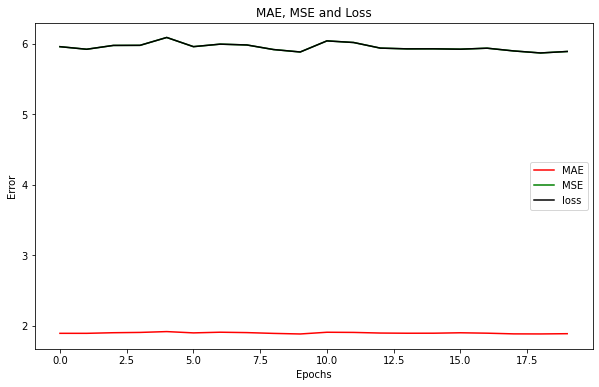

In [ ]:
#@title **code** plot performance

mae = history.history['mae']
mse = history.history['mse']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

**Finally, we can forecasting with RNN model**

In [ ]:
#@title **code**  we can run same walk forward over time steps in validation and test

validation_init = int(len_n*0.7)
test_init = int(len_n*0.9)

forecast_validation = []
forecast_test = []
for t in range(len_n-1):
    if t >= validation_init and t < test_init:
        # Don't forget to add the extra axis to predict
        forecast_validation.append(model.predict(serie[t-window_size:t][np.newaxis]))
    elif t >= test_init:
        forecast_test.append(model.predict(serie[t-window_size:t][np.newaxis]))

# delete 1 dimensions to plot results
forecast_validation = np.squeeze(np.array(forecast_validation))
forecast_test = np.squeeze(np.array(forecast_test))     

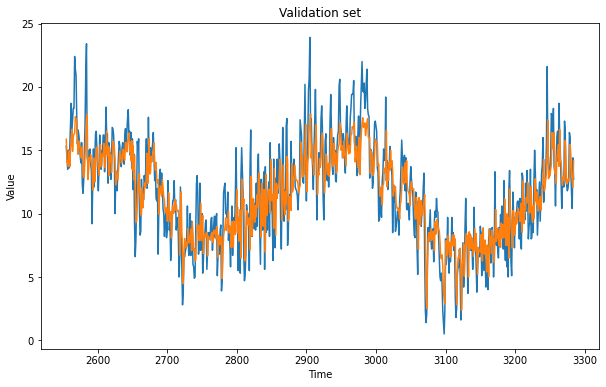

MSE in validation set 5.2862697
MAE in validation set 1.811044


In [ ]:
#@title plot forecast in validation { display-mode: "form" }
plt.figure(figsize=(10, 6))
plt.title('Validation set')
plot_series(time_sets[1], series_sets[1])
plot_series(time_sets[1], forecast_validation)
plt.show()
print('MSE in validation set', tf.keras.metrics.mean_squared_error(series_sets[1], forecast_validation).numpy())
print('MAE in validation set', tf.keras.metrics.mean_absolute_error(series_sets[1], forecast_validation).numpy())

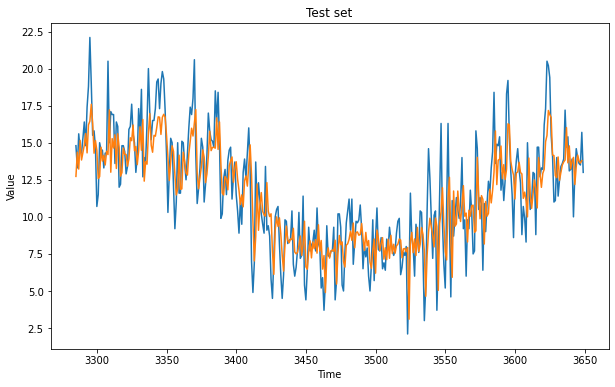

MSE in test set 5.023274
MAE in test set 1.7427707


In [ ]:
#@title plot forecast in test { display-mode: "form" }
plt.figure(figsize=(10, 6))
plt.title('Test set')
plot_series(time_sets[2], series_sets[2])
plot_series(time_sets[2][:-1], forecast_test)
plt.show()

print('MSE in test set', tf.keras.metrics.mean_squared_error(series_sets[2][:-1], forecast_test).numpy())
print('MAE in test set', tf.keras.metrics.mean_absolute_error(series_sets[2][:-1], forecast_test).numpy())


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Change optimizer retrain and plot
- Put a dense layer before dense linear output with relu activation. Evalaute the model.
- Until now you have explored only trainin set prediction. Now built a test dataset, predict and plot w.r.t the original plot. Uses as training 70% and test 30% of original serie


In [ ]:
#@title **code student** Change optimizer retrain and plot
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model.compile( ....)  
# fit
history = model.fit(....)


validation_init = int(len_n*0.7)
test_init = int(len_n*0.9)

forecast_validation = []
forecast_test = []
for t in range(len_n-1):
    if t >= validation_init and t < test_init:
        # Don't forget to add the extra axis to predict
        forecast_validation.append(model.predict(serie[t-window_size:t][np.newaxis]))
    elif t >= test_init:
        forecast_test.append(model.predict(serie[t-window_size:t][np.newaxis]))

# delete 1 dimensions to plot results
forecast_validation = np.squeeze(np.array(forecast_validation))
forecast_test = np.squeeze(np.array(forecast_test))     


plt.figure(figsize=(10, 6))
plt.title('Test set')
plot_series(time_sets[2], series_sets[2])
plot_series(time_sets[2][:-1], forecast_test)
plt.show()

print('MSE in test set', tf.keras.metrics.mean_squared_error(series_sets[2][:-1], forecast_test).numpy())
print('MAE in test set', tf.keras.metrics.mean_absolute_error(series_sets[2][:-1], forecast_test).numpy())


In [ ]:
#@title **code student** Put a dense layer before dense linear output. Evalaute the model.

# Define the layers ######################################################## 
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

......
......




model2 = tf.keras.Model(inputs=input_, outputs=y)
model2.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
InputTransform (Lambda)      (None, 30, 1)             0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 30, 20)            440       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
relu_layer (Dense)           (None, 10)                210       
_________________________________________________________________
ouput_layer (Dense)          (None, 1)                 11        
Total params: 1,481
Trainable params: 1,481
Non-trainable params: 0
_________________________________________________________

In [ ]:
#@title **code student** 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model2.compile(...)  
# fit
history = model2.fit(dataset,epochs=100,verbose=1)


validation_init = int(len_n*0.7)
test_init = int(len_n*0.9)

forecast_validation = []
forecast_test = []
for t in range(len_n-1):
    if t >= validation_init and t < test_init:
        # Don't forget to add the extra axis to predict
        forecast_validation.append(model.predict(serie[t-window_size:t][np.newaxis]))
    elif t >= test_init:
        forecast_test.append(model.predict(serie[t-window_size:t][np.newaxis]))

# delete 1 dimensions to plot results
forecast_validation = np.squeeze(np.array(forecast_validation))
forecast_test = np.squeeze(np.array(forecast_test))     


plt.figure(figsize=(10, 6))
plt.title('Test set')
plot_series(time_sets[2], series_sets[2])
plot_series(time_sets[2][:-1], forecast_test)
plt.show()

print('MSE in test set', tf.keras.metrics.mean_squared_error(series_sets[2][:-1], forecast_test).numpy())
print('MAE in test set', tf.keras.metrics.mean_absolute_error(series_sets[2][:-1], forecast_test).numpy())


In [ ]:
#@title **code student** create a dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # ....
    return dataset

In [ ]:
#@title **code student** Split dataset in train and test. Then plot estimations.

window_size = 30 # number of features in a window
batch_size = 128 # number of samples 
shuffle_buffer_size = 1000 # shuffle the first 1000 samples
per_test = 0.3 # percentage of data to test

# Split series into train, validation and test 
# load data
data_tem = pd.read_csv("data/dailyMin_temperatures.csv")
serie = data_tem.Temp.values
len_n = len(serie)
print("lent serie: ", len_n)
time = data_tem.index.values
time_sets, series_sets = ...
print(len(series_sets), "train: ", len(series_sets[0]), " test: ", len(series_sets[2]))

lent serie:  3650
3 train:  2555  test:  1095


(1065, 1)


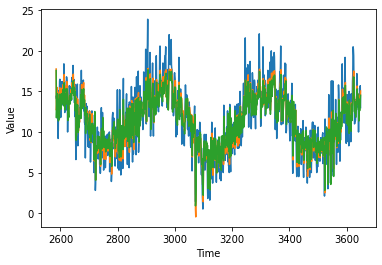

In [ ]:
#@title **code student** predict results and plot
testPredict_1  = ...
testPredict_2  = ...
print(testPredict_1.shape)
plot_series(time_sets[2][window_size:], series_sets[2][window_size:])
plot_series(time_sets[2][window_size:], testPredict_1)
plot_series(time_sets[2][window_size:], testPredict_2)


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Forecasting of IBM stock market index. Please load the dataset in data : 

```
datasets_8388_11883_IBM_2006-01-01_to_2018-01-01
```
 Use only one serie (High, for instance) to train and configurate RNN.

In [ ]:
data_IBM = pd.read_csv("data/datasets_8388_11883_IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
print(data_IBM.shape)
data_IBM.head(5)

In [ ]:
data_IBM.plot(subplots=True, figsize=(10,5));

In [ ]:
#@title **code student** select for training all dataes until 2016
#@markdown we only we should to consider **HIGH**

#@markdown for test use 2017 data
set_entrenamiento = ...
set_test = ...
set_entrenamiento.head(3)

In [ ]:
#@title **code student** we typically should normalize data to obtain a better performance
#@markdown Use MaxMinscaler to scale trainin set betwwen [0-1]

#@markdown Reshape to (data,)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = ...
set_test_escalado = ...
set_entrenamiento_escalado = set_entrenamiento_escalado.reshape(set_entrenamiento_escalado.shape[0])
set_test_escalado = set_test_escalado.reshape(set_test_escalado.shape[0])

In [ ]:
#@title **code** code (set_entrenamiento_escalado) 
#@markdown into a dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position, 
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # choose t --> t-1 as a features and the last one as a label
    # [0, 1, 2, 3][4]
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # shuffle the data
    if (shuffle_buffer is not 0):
      print("shuffle")
      dataset = dataset.shuffle(shuffle_buffer)
    # Generate the batches
    # x = [[0, 1, 2, 3], [4, 5, 6, 7]]
    # y = [[4], [8]]
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size=50
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=32, shuffle_buffer=100)

In [ ]:
for i, (x,y) in enumerate(train_data):
  if i == 0:
    print('Number of samples in each batch: ', x.numpy().shape[0])
    print('Number of labels in each batch: ', y.numpy().shape[0])
    print('Number of features of each sample (temperature days): ', x.numpy().shape[1])
    print('---------------------')
    print('X_1 = \n', x.numpy()[1])
    print('\n')
    print('Y_1 = ', y.numpy()[1])

In [ ]:
#@title **code** Building  the RNN model

# Define the layers ######################################################## 
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input(window_size)
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model_3 = tf.keras.Model(inputs=input_, outputs=y)
model_3.summary()

In [ ]:
#@title **code student** define model parameters
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_3.compile(....)  
# fit
history = model_3.fit(train_data,epochs=5,verbose=1)
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

In [ ]:
#@title **code student** evaluate for training and test
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=32, shuffle_buffer=0)
test_data = windowed_dataset(set_test_escalado, window_size, batch_size=32, shuffle_buffer=0)

train_IBM  = ...
test_IBM  = ...
print(train_IBM.shape, test_IBM.shape)


train_pred = sc.inverse_transform(train_IBM)

time = data_IBM.index.values
print(train_pred.shape)
plt.plot(set_entrenamiento.index.values[0:train_pred.shape[0]], train_pred[:,0],color='blue', label='predicted')
plt.plot(set_entrenamiento.index.values[0:train_pred.shape[0]], set_entrenamiento.High.values[0:train_pred.shape[0]], color='red', label='real')

In [ ]:
#@title **code student** plot the test
pred_test = sc.inverse_transform(test_IBM)
plt.plot(set_test.index.values[0:test_IBM.shape[0]], pred_test[:,0],color='blue', label='predicted')
plt.plot(set_test.index.values[0:test_IBM.shape[0]], set_entrenamiento.High.values[0:test_IBM.shape[0]],color='blue', label='predicted')

### **Some conclusions**
- RNN are sufficient to follow and forecasting temporal series with marked patterns

- In more complex dataset looks no sufficient to forecast series (short memory)

### **4.2 Built a multivariate RNN architecture**

Much of the problems can be described by multiple variables and we can take advantage of these additional features to better represent our problem.  In tensorflow the input configuration follow next tensor structure. 

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/dim_rnn.png" width="450" height="380">

In [ ]:
#@title **code** load the dataset
data_IBM = pd.read_csv("data/datasets_8388_11883_IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
print(data_IBM.shape)
data_IBM.head(5)    

In [ ]:
#@markdown **code** Load multivariate dataset
set_entrenamiento = data_IBM[:'2016'].iloc[:,1:5]
set_test = data_IBM['2017':].iloc[:,1:5]
set_entrenamiento.head(3)

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Now, you should implement a RNN multivariate using the four values. 

- Implement the dataset for this configuration
- Define and architecture that receive the n_features: 

```
input_ = tf.keras.layers.Input((window_size, features))
```
- Evaluate the model with and without scale factor. 
- Review Taller 2

# References

[1. Forecasting: principles and practique](https://otexts.com/fpp2/)

[2. Sequences, Time Series and Prediction](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/)

[3. RNN in tensorflow](https://www.tensorflow.org/guide/keras/rnn)


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">